In [1]:
import torch
import pytorch_lightning as pl
from audtorch.metrics import PearsonR
from contrastive_data import EEG_Dataset
from torchmetrics.wrappers import Running
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import DataLoader,TensorDataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,ModelSummary
import os
from contrastive_net import EEG_Conformer
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn
torch.set_float32_matmul_precision('medium')
import torchaudio
from info_nce import InfoNCE, info_nce

In [2]:
def findfiles(search_dir, subjectstring):
    matching_files = []

    for dirpath, _, filenames in os.walk(search_dir):
        for filename in filenames:
            if subjectstring in filename:
                full_path = os.path.join(dirpath, filename)
                matching_files.append(full_path)

    return matching_files

In [3]:
class Pearsonr(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,P,O):

        (n,c,d) = O.shape      # n traces of t samples

        DO = O - (torch.einsum("ncd->n", O) / (c*d)).reshape(-1,1,1) # compute O - mean(O)
        DP = P - (torch.einsum("ncd->n", P) / (c*d)).reshape(-1,1,1) # compute P - mean(P)

        cov = torch.einsum("ncd,mcd->nm", DP, DO)
        varP = torch.einsum("nm...,nm...->n", DP, DP)
        varO = torch.einsum("nt...,nt...->n", DO, DO)
        tmp = torch.einsum("m,t->mt", varP, varO)

        return cov / torch.sqrt(tmp)

In [5]:
class CLIP(torch.nn.Module):
    def __init__(self,scale,temp,bias,acc=False):
        super().__init__()
        self.scale = scale
        self.temp = temp
        self.acc = acc
        self.bias=bias
        self.pr = Pearsonr()
    
    def forward(self,eemb,aamb):

        n = eemb.size(0)
        

        if self.scale:
            eemb =(eemb - eemb.mean(dim=(1,2),keepdim=True))/eemb.std(dim=(1,2),keepdim=True)
            aamb =(aamb - aamb.mean(dim=(1,2),keepdim=True))/aamb.std(dim=(1,2),keepdim=True)


        labels = torch.arange(len(eemb),device=aamb.device)
    
        logits = self.pr(eemb,aamb)*torch.exp(self.temp) + self.bias


        if self.acc:
            return logits

        return torch.nn.functional.cross_entropy(logits,labels)

In [7]:
class EnvConv(nn.Module):

    def __init__(self,seconds=3):
        super().__init__()
        self.conv = nn.Conv1d(129,64,kernel_size=3,padding="same")
        self.pool = nn.MaxPool1d(64)
    def forward(self,x):
        x = self.conv(x)
        x = x.transpose(1,2)
        x = self.pool(x)
        x = x.squeeze(-1)
        return x

In [8]:
class SubjectLayers(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_subjects: int):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_subjects, in_channels, out_channels))
        self.weights.data *= 1 / in_channels**0.5

    def forward(self, x, subjects):
        _, C, D = self.weights.shape
        weights = self.weights.gather(0, subjects.view(-1, 1, 1).expand(-1, C, D))
        return torch.einsum("bct,bcd->bdt", x, weights)

In [9]:
class EEGConv(nn.Module):

    def __init__(self,seconds=3):
        super().__init__()
        self.subconv = SubjectLayers(64,64,33)
        self.conv = nn.Conv1d(64,64,kernel_size=9,padding="same")
        self.lin = nn.LazyLinear(192)
        self.pool = nn.MaxPool1d(64)
    def forward(self,x,subject):
        x = self.subconv(x,subject)
        x = self.conv(x)
        x = x.transpose(1,2)
        x = self.pool(x)
        x = x.squeeze(-1)
        return x

In [10]:
e = EEGConv()
r = torch.Tensor(np.array([5])).to(torch.int64)
x = torch.rand(32,64,64*3)
out = e(x,r)

c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
out.shape

torch.Size([32, 192])

In [20]:
class Encode(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #self.encoder = EEG_Conformer(nblock=2,nheads=2,dropout=0.5,kernel_size=5,seconds=3)
        self.encoder = EEGConv(seconds=2)
        self.temp = torch.nn.Parameter(torch.log(torch.ones(1)))
        self.bias = torch.nn.Parameter(torch.ones([])*0)
        self.loss_fn = SigLip(scale=True,temp= self.temp,bias=self.bias)
        self.running_loss1 = Running(MeanMetric(), window=32)
        self.running_loss22 = Running(MeanMetric(),window=32)
        self.running_loss = Running(MeanMetric(), window=32)
        self.running_loss2 = Running(MeanMetric(),window=32)
        self.tracc = Running(MeanMetric(),window=32)
        self.valacc = Running(MeanMetric(),window=32)
        self.audproj = EnvConv(seconds=3)
        self.binloss = nn.BCELoss()
        #self.acccont = SigLip(scale=True,temp=self.temp,acc=True)

        self.los = PearsonR()
        self.accfn = PearsonR(reduction=None)
        self.lr = 3e-4
        self.loss2 = InfoNCE(negative_mode='unpaired')
    

    def forward(self, eeg):
        # in lightning, forward defines the prediction/inference actions
        hidden = self.encoder(eeg)
        return hidden

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas,_,subject = batch

        eeg_emb = self.encoder(eeg,subject)
        
        attf = self.audproj(att)
        masf = self.audproj(mas)

        #comb = torch.concatenate((attf,masf))



        #loss2 = -self.los(eeg_emb,attf) + self.los(eeg_emb,masf) 
        loss =  self.loss2(eeg_emb,attf,masf)
        


        self.running_loss(loss)
        #self.running_loss1(loss2)
        


        self.log('train_loss', self.running_loss.compute(), on_step=True, prog_bar=True)
        #self.log('train_pearson_loss', self.running_loss1.compute(), on_step=True, prog_bar=True)
        #self.log('train_accuracy',)

        #m1 = torch.diagonal(self.acccont(eeg_emb,attf))
        #m2 = torch.diagonal(self.acccont(eeg_emb,masf))



        

        m1 = self.accfn(eeg_emb,attf)
        m2 = self.accfn(eeg_emb,masf)

        




        acc = torch.sum(m1>m2)/m1.shape[0]
        self.tracc(acc)
        self.log("train_accuracy",self.tracc.compute(),prog_bar=True,on_step=True)
        
    


        return loss

    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas,_,subject = batch

        eeg_emb = self.encoder(eeg,subject)
        
        attf = self.audproj(att)
        masf = self.audproj(mas)

        #comb = torch.concatenate((attf,masf))





        #loss2 = -self.los(eeg_emb,attf) + self.los(eeg_emb,masf) 
        #loss1 = self.loss_fn(eeg_emb,att)
        loss =  self.loss2(eeg_emb,attf,masf)

        self.running_loss2(loss)
        #self.running_loss22(loss2)

        

        self.log('val_loss', self.running_loss2.compute(), on_step=True, prog_bar=True)
        #self.log('val_loss', self.running_loss22.compute(), on_epoch=True, prog_bar=True)

        m1 = self.accfn(eeg_emb,attf)
        m2 = self.accfn(eeg_emb,masf)

        #m1 = torch.diagonal(self.acccont(eeg_emb,attf))
        #m2 = torch.diagonal(self.acccont(eeg_emb,masf))

        acc = torch.sum(m1>m2)/m1.shape[0]
        self.valacc(acc)
        self.log("val_accuracy",self.valacc.compute(),prog_bar=True,on_step=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,800)
        return [optimizer],[scheduler]

In [21]:
dir = "Try2/"

In [22]:
train = {}
val = {}
test = {}

for i in range(1,33):
    if i ==14:
        continue
    substr = "subject_" + str(i) + "_"

    subjectlist = findfiles(dir,substr)
    spfiles,testfiles = train_test_split(subjectlist,test_size=0.1,random_state=42)
    trainfiles,valfiles = train_test_split(spfiles,test_size=0.12,random_state=42)

    train[substr] = trainfiles
    val[substr] = valfiles
    test[substr] = testfiles


In [23]:
trains = sum(train.values(),[])
vals = sum(val.values(),[])
tests = sum(test.values(),[])

In [24]:
import random
random.shuffle(trains)
random.shuffle(vals)
random.shuffle(tests)

In [26]:
tr_dataset = EEG_Dataset(files=trains,seconds=3,overlap=0,fs=64)
val_dataset = EEG_Dataset(files=vals,seconds=3,overlap=0,fs=64)

tr_loader = DataLoader(tr_dataset,batch_size=32,num_workers=3,persistent_workers=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,num_workers=3,persistent_workers=True)

In [27]:
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='./EriksholmFiles/',filename='pretrained_weights',auto_insert_metric_name=False,verbose=True,enable_version_counter=False)
early_stopping = EarlyStopping('val_loss',patience=10)
ms = ModelSummary(max_depth=3)

In [28]:
enc = Encode()

trainer = pl.Trainer(max_epochs=300,accelerator='gpu',callbacks=[checkpoint_callback,ms,early_stopping])
trainer.fit(enc, tr_loader,val_dataloaders=val_loader)

c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
--------------------------------------------------------------
0  | encoder                    | EEGConv       | 172 K 
1  | encoder.subconv            | SubjectLayers | 135 K 
2  | encoder.conv               | Conv1d        | 36.9 K
3  | encoder.lin                | LazyLine

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 596: 'val_loss' reached 3.50003 (best 3.50003), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\EriksholmFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1192: 'val_loss' reached 3.47723 (best 3.47723), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\EriksholmFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1788: 'val_loss' reached 3.46838 (best 3.46838), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\EriksholmFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2384: 'val_loss' reached 3.45866 (best 3.45866), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\EriksholmFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 2980: 'val_loss' reached 3.45185 (best 3.45185), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\EriksholmFiles\\pretrained_weights.ckpt' as top 1
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [39]:
m = tr_dataset.__getitem__(9)

In [46]:
enc = enc.cpu()

In [50]:
out = enc.encoder(m[0].unsqueeze(0),m[4])

In [65]:
enc.temp

Parameter containing:
tensor([0.3138], requires_grad=True)

In [63]:
m[1][0].mean()

tensor(-3.5390e-08)

In [17]:
m = torch.Tensor(np.array([44]))
r = torch.Tensor(np.array([1]))
torch.stack((m,r))

tensor([[44.],
        [ 1.]])

In [20]:
k = tr_dataset.__getitem__(8)[4]

[10]


In [21]:
k

tensor([10])

In [12]:
from IPython.display import Audio

Audio(k[2][0].numpy(),rate=16000)

In [53]:
k = torch.abs(out)

In [20]:
mod = Encode.load_from_checkpoint("./EriksholmFiles/pretrained_weights.ckpt")

c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
def predict(loader,test_model):
    test_loss = []
    test_metric = []
    test_masker = []
    acc = []

    with torch.no_grad():
        for batch_data in loader:
            inputs, outputs,masker,subj = batch_data[0], batch_data[1],batch_data[2],batch_data[4]
            
            # Forward pass
            predictions = test_model.encoder(inputs,subj)
            enva = test_model.audproj(outputs)
            envm = test_model.audproj(masker)

            # Compute loss
            loss = -PearsonR()(enva, predictions).mean()

            # Compute metric
            metric = torch.mean(PearsonR(reduction=None)(enva, predictions),dim=1)
            metric2 = torch.mean(PearsonR(reduction=None)(envm, predictions),dim=1)
            accu = torch.sum(metric>metric2)

            test_loss.append(loss.item())
            test_metric.extend(metric.detach().cpu().numpy().reshape(-1))
            test_masker.extend(metric2.detach().cpu().numpy().reshape(-1))
            acc.append(accu.cpu().detach().numpy())
    
    return test_loss,np.array(test_metric),np.array(test_masker),np.array(acc)

In [22]:
accuracy = []
metric = []
masker = []
from tqdm import tqdm
mod = mod.cpu().eval()
for i in tqdm(range(1,33)):
    if i ==14:
        continue

    subject = "subject_" + str(i) + "_"
    sub_dataset = EEG_Dataset(files=val[subject],seconds=3,overlap=0,fs=64)
    test_loader = DataLoader(sub_dataset,batch_size=1)

    out = predict(test_loader,mod)

    accuracy.append(np.mean(out[3]))
    metric.append(out[1])
    masker.append(out[2])



100%|██████████| 32/32 [00:42<00:00,  1.31s/it]


<BarContainer object of 31 artists>

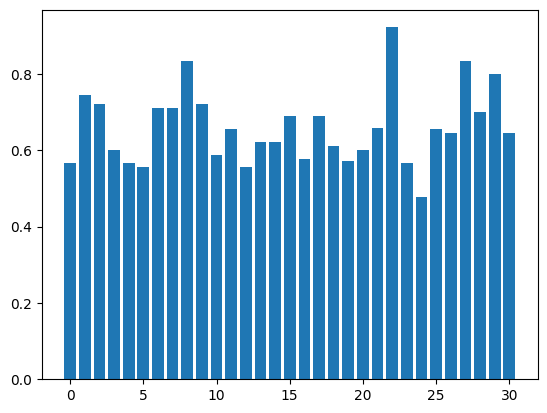

In [23]:
import matplotlib.pyplot as plt
plt.bar(np.arange(len(accuracy)),accuracy)

In [24]:
np.mean(accuracy)

0.6586277521761393

In [25]:
accuracy

[0.5666666666666667,
 0.7444444444444445,
 0.7222222222222222,
 0.6,
 0.5666666666666667,
 0.5555555555555556,
 0.7111111111111111,
 0.7111111111111111,
 0.8333333333333334,
 0.7222222222222222,
 0.5888888888888889,
 0.6555555555555556,
 0.5555555555555556,
 0.6222222222222222,
 0.6222222222222222,
 0.6888888888888889,
 0.5777777777777777,
 0.6888888888888889,
 0.6111111111111112,
 0.5714285714285714,
 0.6,
 0.6571428571428571,
 0.9222222222222223,
 0.5666666666666667,
 0.4777777777777778,
 0.6555555555555556,
 0.6444444444444445,
 0.8333333333333334,
 0.7,
 0.8,
 0.6444444444444445]

In [33]:
k = [z - i for z,i in zip(attmeans,masmeans)]

<BarContainer object of 31 artists>

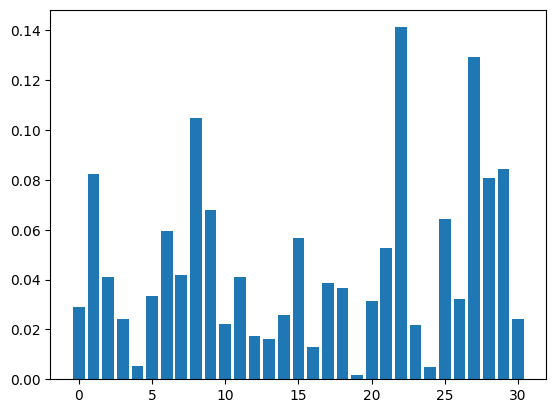

In [34]:
plt.bar(np.arange(len(k)),k)

In [26]:
met = [np.squeeze(k) for k in metric]
mas = [np.squeeze(k) for k in masker]

In [27]:
attmeans = [np.mean(r) for r in met]
masmeans = [np.mean(r) for r in mas]

<BarContainer object of 31 artists>

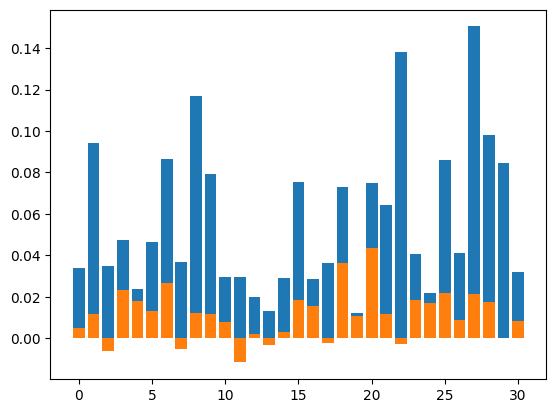

In [28]:
plt.bar(np.arange(len(attmeans)),attmeans)
plt.bar(np.arange(len(masmeans)),masmeans)

{'whiskers': [<matplotlib.lines.Line2D at 0x26f10ac33d0>,
 'caps': [<matplotlib.lines.Line2D at 0x26f10ac3910>,
 'boxes': [<matplotlib.lines.Line2D at 0x26f10ac3130>,
 'medians': [<matplotlib.lines.Line2D at 0x26f10ac3e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x26f10af8130>,
 'means': []}

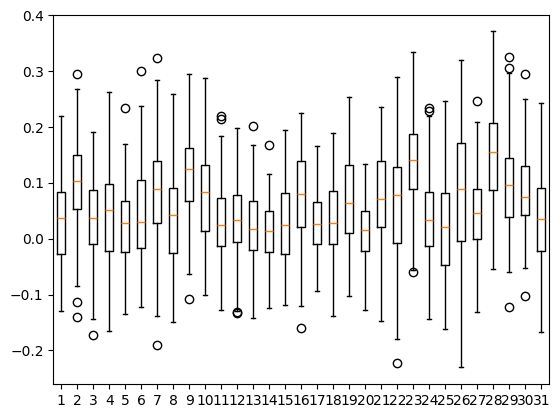

In [29]:
plt.boxplot(met)
#plt.boxplot(np.arange(len(masmeans)),mas)

{'whiskers': [<matplotlib.lines.Line2D at 0x26f2c0f80a0>,
 'caps': [<matplotlib.lines.Line2D at 0x26f2c0f92a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26f2c0f8340>,
 'medians': [<matplotlib.lines.Line2D at 0x26f2c0fa770>,
 'fliers': [<matplotlib.lines.Line2D at 0x26f2c0fafb0>,
 'means': []}

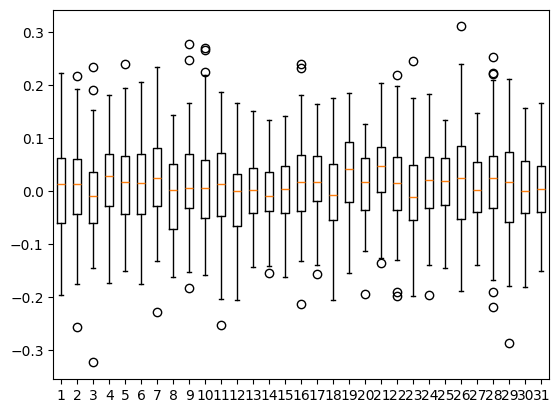

In [30]:
plt.boxplot(mas)

In [31]:
np.mean(masmeans)

0.01134984

In [32]:
np.mean(attmeans)

0.05736066